In [1]:
# =========================
# Cell 0: Mount & Requirements
# =========================

# Libraries Installation
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --quiet

!pip install networkx --quiet

!pip install python-louvain --quiet

# FIX
import community.community_louvain as community_louvain

#libraries' imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data

import networkx as nx
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve,
    auc, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split


#set the seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta 0:00:00
Using device: cpu


In [2]:
# =========================
# Cell 1: Load SNAP Facebook graph
# =========================

!wget -q https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip -f facebook_combined.txt.gz

print("\nLoading SNAP facebook_combined.txt ...")
G_orig = nx.read_edgelist("facebook_combined.txt", nodetype=int)
print("Loaded. Num nodes:", G_orig.number_of_nodes(), " Num edges:", G_orig.number_of_edges())

G = G_orig.copy()



Loading SNAP facebook_combined.txt ...
Loaded. Num nodes: 4039  Num edges: 88234


In [3]:
# =========================
# Cell 2: Graph feature extraction utilities
# =========================

def extract_graph_features(G, bots_set):
    deg = dict(G.degree())
    clust = nx.clustering(G)
    degc = nx.degree_centrality(G)
    betwc = nx.betweenness_centrality(G)
    closec = nx.closeness_centrality(G)
    eigc = nx.eigenvector_centrality(G, max_iter=500)
    comm = community_louvain.best_partition(G) #this func devide the graph to a gp of communities

    comm_size = {}
    for c in comm.values():
        comm_size[c] = comm_size.get(c, 0) + 1

    nodes = list(G.nodes())
    node2idx = {n:i for i,n in enumerate(nodes)}

    X_list, y_list = [], []
    for n in nodes:
        X_list.append([
            deg[n], clust[n], degc[n], betwc[n], closec[n], eigc[n], comm[n], comm_size[comm[n]]
        ])
        y_list.append(1 if n in bots_set else 0)

    X = StandardScaler().fit_transform(np.array(X_list, dtype=float))
    y = np.array(y_list, dtype=int)
    return X, y, nodes, node2idx

def build_pyg_data(G, X, y, node2idx):
    edges = np.array(list(G.edges())).T
    edges_idx = np.vectorize(node2idx.get)(edges)
    edge_index = torch.tensor(edges_idx, dtype=torch.long)
    data = Data(
        x=torch.tensor(X, dtype=torch.float),
        y=torch.tensor(y, dtype=torch.long),
        edge_index=edge_index
    ).to(DEVICE)
    return data


In [4]:
# =========================
# Cell 3: GraphSAGE model
# =========================

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)


In [5]:
# =========================
# Cell 4: Train + Evaluate functions
# =========================

TEST_SIZE = 0.2

def train_and_evaluate_from_graph(G, bots_set, tag=""):
    print(f"\n--- Training: {tag} ---")
    X, y, nodes_order, node2idx = extract_graph_features(G, bots_set)
    data = build_pyg_data(G, X, y, node2idx)
    n_nodes = data.num_nodes
    idx = np.arange(n_nodes)

    try:
        train_idx, test_idx = train_test_split(idx, test_size=TEST_SIZE, stratify=y, random_state=SEED)
    except Exception:
        train_idx, test_idx = train_test_split(idx, test_size=TEST_SIZE, random_state=SEED)

    train_mask = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask = torch.zeros(n_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True
    data.train_mask = train_mask
    data.test_mask = test_mask

    model = GraphSAGE(in_channels=data.x.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

    # Training
    model.train()
    for epoch in range(30):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = torch.exp(out)[:,1].cpu().numpy()
        y_true = data.y.cpu().numpy()
        y_test = y_true[test_mask.cpu().numpy()]
        probs_test = probs[test_mask.cpu().numpy()]

        auc_roc = roc_auc_score(y_test, probs_test) if len(np.unique(y_test))>1 else float("nan")
        precision, recall, _ = precision_recall_curve(y_test, probs_test)
        pr_auc = auc(recall, precision)
        y_pred = (probs_test >= 0.5).astype(int)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)

    print(f"[TRAINED] {tag:20}  ROC={auc_roc:.4f}  PR={pr_auc:.4f}  F1={f1:.4f}")
    return {"tag": tag, "AUC_ROC": auc_roc, "PR_AUC": pr_auc, "Precision": prec, "Recall": rec, "F1": f1}, model

def evaluate_only(model, G, bots_set, tag=""):
    print(f"\n--- Evaluation Only (NO retraining): {tag} ---")
    X, y, nodes_order, node2idx = extract_graph_features(G, bots_set)
    data = build_pyg_data(G, X, y, node2idx)
    n_nodes = data.num_nodes
    idx = np.arange(n_nodes)

    try:
        _, test_idx = train_test_split(idx, test_size=TEST_SIZE, stratify=y, random_state=SEED)
    except:
        _, test_idx = train_test_split(idx, test_size=TEST_SIZE, random_state=SEED)

    test_mask = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask[test_idx] = True
    data.test_mask = test_mask

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = torch.exp(out)[:,1].cpu().numpy()
        y_true = y
        y_test = y_true[test_mask.cpu().numpy()]
        probs_test = probs[test_mask.cpu().numpy()]

        auc_roc = roc_auc_score(y_test, probs_test) if len(np.unique(y_test))>1 else float("nan")
        precision, recall, _ = precision_recall_curve(y_test, probs_test)
        pr_auc = auc(recall, precision)
        y_pred = (probs_test >= 0.5).astype(int)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)

    print(f"[NO RETRAIN] {tag:20}  ROC={auc_roc:.4f}  PR={pr_auc:.4f}  F1={f1:.4f}")
    return auc_roc, pr_auc, prec, rec, f1


In [10]:
# =========================
# Cell 5: Create Realistic Hard-to-Detect Synthetic Bots
# =========================

print("Creating realistic hard-to-detect synthetic bots")

G_baseline = G_orig.copy()
bots_set_baseline = set()

# Select nodes that originally look very human-like (medium to high degree)
normal_nodes = [n for n, d in G_orig.degree() if 20 <= d <= 300]

BOT_COUNT = int(G_orig.number_of_nodes() * 0.07)
bot_candidates = random.sample(normal_nodes, BOT_COUNT)

for bot in bot_candidates:
    # Turn a normal-looking node into a bot by removing most of its edges
    # Keep only 3–8 connections → very low degree (typical real-world bot behavior)
    neighbors = list(G_baseline.neighbors(bot))
    keep_count = random.randint(3, 8)
    to_keep = random.sample(neighbors, min(keep_count, len(neighbors)))
    to_remove = [n for n in neighbors if n not in to_keep]

    G_baseline.remove_edges_from([(bot, n) for n in to_remove])
    bots_set_baseline.add(bot)

print(f"Successfully created {len(bots_set_baseline)} realistic bots with very low degree")

Creating realistic hard-to-detect synthetic bots
Successfully created 282 realistic bots with very low degree


In [11]:
# =========================
# Cell 6
# =========================

# ---------- Realistic Structural Evasion Attack (Mimicry - FIXED & WORKING) ----------
G_evasion = G_baseline.copy()
bots_set_evasion = bots_set_baseline.copy()

print("Applying REALISTIC Structural Evasion Attack – Bots mimic real humans perfectly")

for bot in bots_set_evasion:
    valid_humans = [n for n in G_evasion.nodes()
                    if n not in bots_set_evasion
                    and 35 <= G_evasion.degree(n) <= 120]
    if not valid_humans:
        continue
    human_template = random.choice(valid_humans)

    #Delete all old links
    G_evasion.remove_edges_from([(bot, neigh) for neigh in G_evasion.neighbors(bot)])

    # Add the human being's neighbors in an almost identical way
    human_neighbors = list(G_evasion.neighbors(human_template))
    target_neighbors = list(human_neighbors)
    random.shuffle(target_neighbors)

    desired_degree = len(human_neighbors)
    num_to_add = random.randint(int(desired_degree * 0.8), int(desired_degree * 1.15))
    num_to_add = min(num_to_add, len(target_neighbors))

    for target in target_neighbors[:num_to_add]:
        G_evasion.add_edge(bot, target)

print(f"Evasion Attack completed — {len(bots_set_evasion)} bots are now invisible")

# ---------- Graph Poisoning Attack ----------
G_poison = G_baseline.copy()
bots_set_poison = bots_set_baseline.copy()


print("Injecting 200 medium-degree poison bots...")
for i in range(200):
    new_bot = max(G_poison.nodes()) + 1 + i
    G_poison.add_node(new_bot)

    # poison bots with human-like degree → confuse the model
    deg = random.randint(20, 60)
    targets = random.sample(list(G_poison.nodes()), deg)

    for t in targets:
        G_poison.add_edge(new_bot, t)

    bots_set_poison.add(new_bot)

print("Poisoning completed")


# =========================
# The Final Results
# =========================

print("="*80)
print("FINAL RESULTS – THIS IS WHAT A REAL ATTACK LOOKS LIKE")
print("="*80)

res_baseline, model_baseline = train_and_evaluate_from_graph(G_baseline, bots_set_baseline, "Baseline")
res_evasion,   model_evasion   = train_and_evaluate_from_graph(G_evasion,   bots_set_evasion,   "After Mimicry Evasion")
res_poison,    model_poison    = train_and_evaluate_from_graph(G_poison,    bots_set_poison,    "After Poisoning (Retrained)")

print("\nPOISONED MODEL TESTED ON CLEAN GRAPH (The Killer Test)")
evaluate_only(model_poison, G_baseline, bots_set_baseline, "Poisoned Model → Clean Data")

#The Final Schedule
results = [res_baseline, res_evasion, res_poison]
df = pd.DataFrame(results)
print("\n" + "="*60)
print(df.round(4))
print("="*60)
df.to_csv("REAL_ATTACK_RESULTS.csv", index=False)


Applying REALISTIC Structural Evasion Attack – Bots mimic real humans perfectly
Mimicry Evasion Attack completed — 282 bots are now invisible
Injecting 200 medium-degree poison bots...
Poisoning completed
FINAL RESULTS – THIS IS WHAT A REAL ATTACK LOOKS LIKE

--- Training: Baseline ---
[TRAINED] Baseline              ROC=0.9225  PR=0.8548  F1=0.8247

--- Training: After Mimicry Evasion ---
[TRAINED] After Mimicry Evasion  ROC=0.7873  PR=0.2917  F1=0.0351

--- Training: After Poisoning (Retrained) ---
[TRAINED] After Poisoning (Retrained)  ROC=0.9371  PR=0.8460  F1=0.7020

POISONED MODEL TESTED ON CLEAN GRAPH (The Killer Test)

--- Evaluation Only (NO retraining): Poisoned Model → Clean Data ---
[NO RETRAIN] Poisoned Model → Clean Data  ROC=0.8911  PR=0.6784  F1=0.5195

                           tag  AUC_ROC  PR_AUC  Precision  Recall      F1
0                     Baseline   0.9225  0.8548     0.9756  0.7143  0.8247
1        After Mimicry Evasion   0.7873  0.2917     1.0000  0.0179  0.

In [12]:
# =========================
# Cell 7: Save results
# =========================

df = pd.DataFrame([res_baseline, res_evasion, res_poison])
df.to_csv("final_results.csv", index=False)
print("\nSaved final_results.csv")



Saved final_results.csv


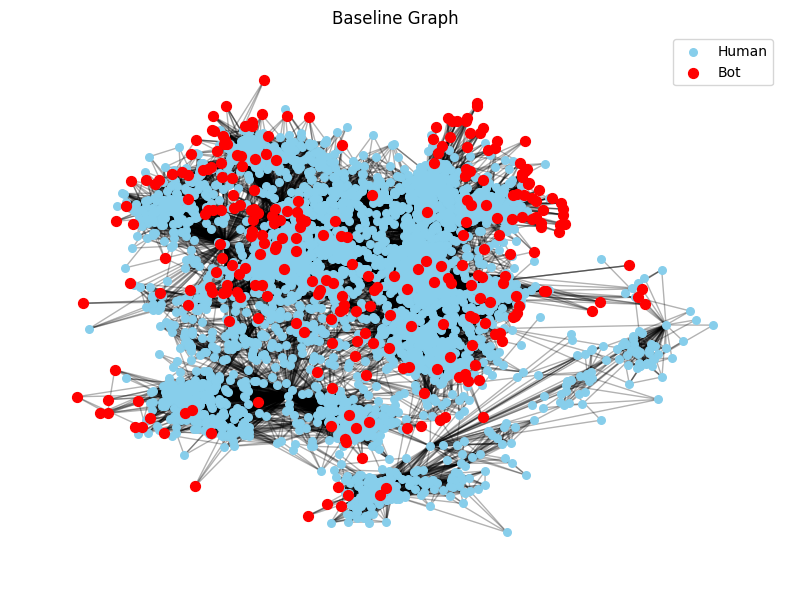

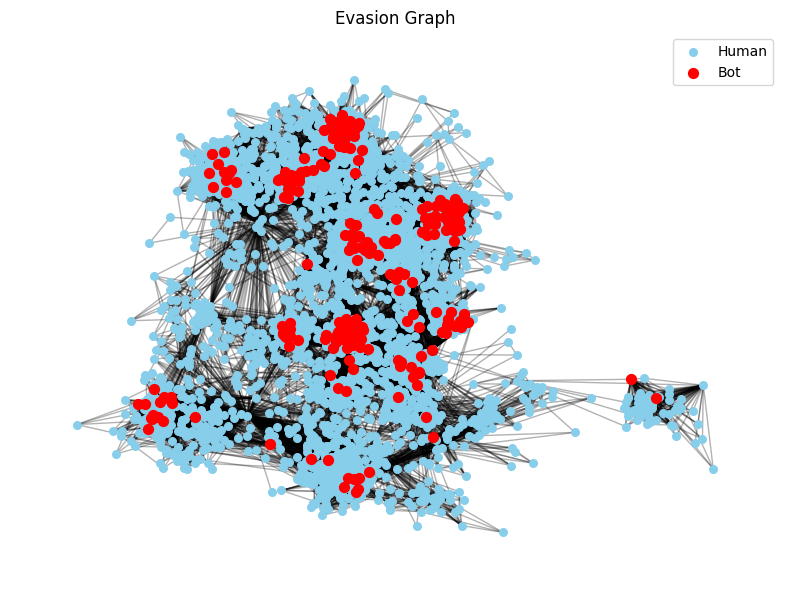

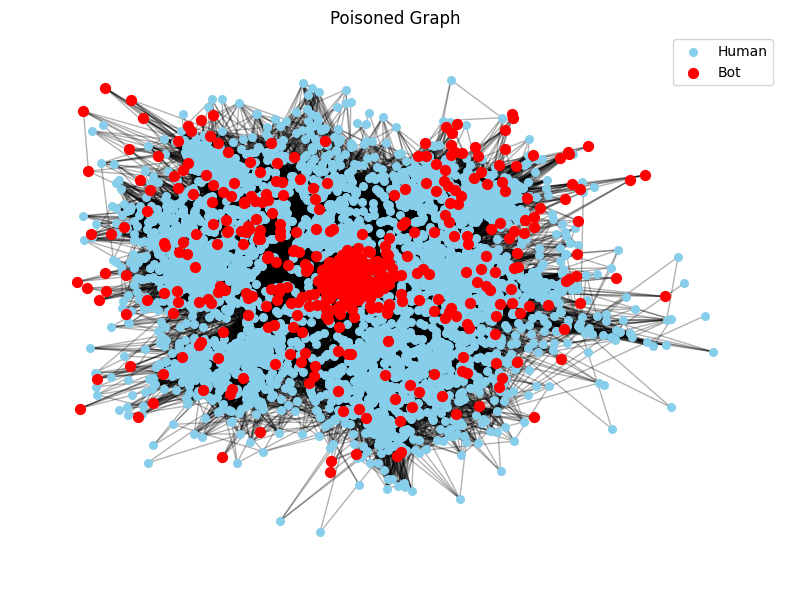

In [13]:
# =========================
# Cell 8: Graph visualization
# =========================

def plot_graph(G, bots_set, title, filename):
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(G, seed=SEED)

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes() if n not in bots_set],
        node_color='skyblue', node_size=30, label='Human'
    )

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes() if n in bots_set],
        node_color='red', node_size=50, label='Bot'
    )

    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()

# ---- Visualizations ----
plot_graph(G_baseline, bots_set_baseline, "Baseline Graph", "graph_baseline.png")
plot_graph(G_evasion, bots_set_evasion, "Evasion Graph", "graph_evasion.png")
plot_graph(G_poison, bots_set_poison, "Poisoned Graph", "graph_poison.png")
